# CSI 4810 - Project 2 - Text Mining Reddit Posts
##### Willow Connelly

---


In [5]:
import praw
import spacy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from spacy import displacy
from wordcloud import WordCloud
from collections import Counter

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

pd.set_option('display.max_colwidth', None)

---
### Read-in Data

In [ ]:
reddit = praw.Reddit(
    client_id="5DEFxmbu1nIVbteepOjXdw",
    client_secret="phSKbMc45hNevM3m-u8U5opnCg3pcg",
    user_agent="CSI4810_p2 version 1 by /u/Worldly_Turnip1077",
)

print(reddit.read_only)
data = []
for submission in reddit.subreddit("politics").top(limit=500,time_filter="month"):
    data.append(submission)
    # print(submission.title)

with open("reddit_submissions.pkl", "wb") as f:
    pickle.dump(data, f)

In [13]:
# read in already collected data so you don't have to call API again
data = []
with open("reddit_submissions.pkl", "rb") as f:
    data = pickle.load(f)

---
### Preprocessing

handling case

In [21]:
titles, ogTitles = [],[]
for d in data:
    ogTitles.append(d.title)
    titles.append(d.title.lower())

nlp

In [22]:
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(titles))

NER


As we can see, the NER from spacy is all over the place. It is highly inaccurate given the original data's capitalization and formatting. It was tested with original data format and data converted to lowercase. Both yield terrible results. Thankfully, the NER is not necessary for topic detection and other methods will be employed instead, namely POS tagging

In [23]:
# with original case
displacy.render(list(nlp.pipe(ogTitles))[:10], style='ent', jupyter=True)

c:\Users\willo_jlqcl0r\miniconda3\envs\textMining\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [24]:
# with lowercase
displacy.render(docs[:10], style='ent' )

---

Stop word removal, lemmatizing, and non word removal

In [25]:
words_to_exclude = {"sanders"}
my_stop_words = {'say'}
cleaned_docs = []

for doc in docs:
    l = []
    for token in doc:
        if (token.is_alpha and not token.is_stop and token.lemma_ not in my_stop_words):
            l.append(token.lemma_ if token.text not in words_to_exclude else token.text)
    cleaned_docs.append(l)

cleaned_docs = [' '.join(tokens) for tokens in cleaned_docs]
cleaned_docs[:10]

['sen bernie sanders win fourth term represent vermont',
 'arnold schwarzenegg endorse kamala harris recognize country',
 'jeff bezos kill washington post endorsement kamala harris paper report',
 'high school student witness fight release damn house ethic report allegation matt gaetz donald trump pick attorney general sex year old girl begin',
 'time hold democratic party elite responsible catastrophe',
 'elon musk ai turn label significant spreader misinformation x',
 'sanders democratic party abandon work class people',
 'kamala harris ask americans go elect guy good thing hitler',
 'texas teen suffering miscarriage die day baby shower abortion ban mom beg doctor',
 'texas woman die hospital crime intervene miscarriage']

---

### Term frequency

In [26]:
vectorizer = CountVectorizer(stop_words='english',binary=False).fit(cleaned_docs) 

transformed = vectorizer.transform(cleaned_docs).toarray()
word_freq = pd.DataFrame(transformed.sum(axis=0).reshape(1,len(vectorizer.vocabulary_)),
                         columns=vectorizer.get_feature_names_out())

print(f"Number of terms selected: {len(vectorizer.vocabulary_)}\n")
print("Most frequent words:\n", word_freq.iloc[0].nlargest(5))

Number of terms selected: 1526

Most frequent words:
 trump       301
harris      107
donald       60
kamala       59
election     47
Name: 0, dtype: int64


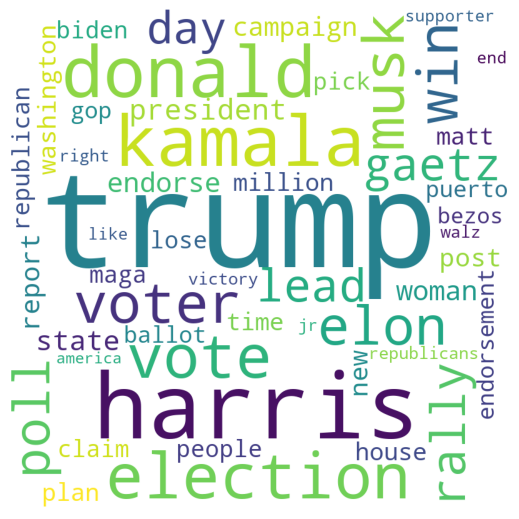

In [27]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(word_freq.iloc[0].nlargest(50).to_dict())

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

---

Topic sentence detection Util Functions

In [28]:
def createDataStruct(clusterNumber):
    ds = {}
    for i in range(clusterNumber):
        ds[i] = {'verb':[],
                 'subj': [],
                 'obj':[],
                 'topic':[]}
    return ds

def extractTopics(clusterNumber,docClusterList):
    topicList = createDataStruct(clusterNumber)
    
    for i,doc in enumerate(docs):
        cluster = docClusterList[i]
        if cluster == -1: continue
        for token in doc:
            if(token.is_alpha and not token.is_stop and token.lemma_ not in my_stop_words):
                if(token.dep_ == 'nsubj'):
                    topicList[cluster]['subj'].append(token.lemma_ if token not in words_to_exclude else token.text)
                if(token.dep_ == 'ROOT'):
                    topicList[cluster]['verb'].append(token.lemma_)
                if(token.dep_ == 'dobj'):
                    topicList[cluster]['obj'].append(token.lemma_ if token not in words_to_exclude else token.text)

    for key,val in topicList.items():
        val['topic'].extend([Counter(val['subj']).most_common(1)[0][0],
                             Counter(val['verb']).most_common(1)[0][0],
                             Counter(val['obj']).most_common(2)[0][0],
                             Counter(val['obj']).most_common(2)[1][0]
                             ])
    return topicList

---
### Topic Detection - tf-idf NMF

In [35]:
tvect = TfidfVectorizer(stop_words='english')
tfidf = tvect.fit_transform(cleaned_docs)

In [53]:
nmf = NMF(beta_loss="kullback-leibler",solver="mu",n_components=20,random_state=42)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("w",W.shape,"\nh",H.shape)

w (500, 20) 
h (20, 1526)


In [54]:
ws = tvect.get_feature_names_out()

topwords=[]
for i,topic in enumerate(H):
    topwords.append(pd.DataFrame(H, columns = ws).iloc[i].nlargest(10).index)

topdoc=[]
for doc in enumerate(W):
    topdoc.append(doc[1].argmax())
topwords = pd.DataFrame([' '.join(tokens) for tokens in topwords],columns=['topic_top_words'])
topwords

,topic_top_words
0,harris kamala poll trump final lead donald deserve iowa defeat
1,donald trump elon look make begin musk confession piss shocking
2,musk elon million lottery pac putin voter philadelphia vladimir misinformation
3,washington post endorsement bezos editor kill jeff democracy paper billionaire
4,gaetz matt report ethic release general attorney nomination ag fox
5,vote gabbard gaetz john tulsi probe oliver fight election wisconsin
6,election suddenly win trump think presidential poll supreme day court
7,vote new lead point poll trump man maga husband woman
8,win state democrat carolina senate north economy race trump republican
9,rally puerto rico support trump garden madison square racist nazi


In [55]:
tfidfTopics = extractTopics(W.shape[1],topdoc)
tfidfTopics = pd.concat([pd.DataFrame([(x,y['topic']) for x,y in tfidfTopics.items()],
                                      columns=['topic_number','topic_desc']), 
                                      topwords], axis=1)
tfidfTopics

,topic_number,topic_desc,topic_top_words
0,0,"[harris, show, trump, lead]",harris kamala poll trump final lead donald deserve iowa defeat
1,1,"[trump, trump, trump, sex]",donald trump elon look make begin musk confession piss shocking
2,2,"[musk, sue, musk, lottery]",musk elon million lottery pac putin voter philadelphia vladimir misinformation
3,3,"[bezos, quit, endorsement, post]",washington post endorsement bezos editor kill jeff democracy paper billionaire
4,4,"[gaetz, begin, report, department]",gaetz matt report ethic release general attorney nomination ag fox
5,5,"[harris, call, election, probe]",vote gabbard gaetz john tulsi probe oliver fight election wisconsin
6,6,"[trump, go, election, win]",election suddenly win trump think presidential poll supreme day court
7,7,"[woman, vote, vote, lead]",vote new lead point poll trump man maga husband woman
8,8,"[harris, win, term, race]",win state democrat carolina senate north economy race trump republican
9,9,"[trump, forget, rally, harris]",rally puerto rico support trump garden madison square racist nazi


In [94]:
topicDocMatrix = pd.concat([pd.DataFrame(titles,columns=["title"]),pd.DataFrame(topdoc,columns=["topic_number"])],
                           axis=1).join(tfidfTopics[['topic_desc','topic_top_words']], on='topic_number')
topicDocMatrix.drop('topic_desc',axis=1)

,title,topic_number,topic_top_words
0,sen. bernie sanders wins a fourth term representing vermont,8,win state democrat carolina senate north economy race trump republican
1,arnold schwarzenegger endorses kamala harris: 'don't recognize our country',2,musk elon million lottery pac putin voter philadelphia vladimir misinformation
2,"jeff bezos killed washington post endorsement of kamala harris, paper reports",3,washington post endorsement bezos editor kill jeff democracy paper billionaire
3,“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun.,4,gaetz matt report ethic release general attorney nomination ag fox
4,this time we have to hold the democratic party elite responsible for this catastrophe,12,people sanders bernie listen jeffrey epstein party class close democratic
...,...,...,...
495,president biden names fifty-sixth round of judicial nominees,14,jr rfk president ban nominee trump health rule gop mcdonald
496,fallout from florida latinos fierce following racist jokes during former president’s nyc rally,17,president endorse woman ricans united states like trump newspaper fury
497,"harris expands her lead over trump to 10 points in virginia, new roanoke college poll says",7,vote new lead point poll trump man maga husband woman
498,donald trump is already looking to gut medicaid: republicans are looking to cut federal assistance programs in order to extend trump's 2017 corporate tax cut.,11,trump republicans deportation america plan mass victory fellow administration death


---

In [106]:
finalizedTopics = pd.concat([pd.DataFrame(["harris leads over trump",
                    "trump news",
                    "elon musk sued for misinformation",
                    "bezos kills washington post's endorsement",
                    'matt gaetz ethics report',
                    'urging voters to vote',
                    'trump election results',
                    'women voters against maga',
                    'term race winners predictions',
                    'trump madison square rally', 
                    'voters reaction to trump comments',
                    "trump, america's czar",
                    "elites didn't listen to the people",
                    'women send a message',
                    'trump nominees',
                    'trump and biden plans',
                    'trump campaign breaks down',
                    'endorsing harris',
                    'ballot and rally turnouts',
                    "trump's losses"],columns=['final_topics']),pd.DataFrame([i for i in range(20)],columns=['topic_number'])],axis=1)
topicDocMatrix.join(finalizedTopics[['final_topics']], on='topic_number').drop(['topic_desc','topic_top_words','topic_number'],axis=1)

,title,final_topics
0,sen. bernie sanders wins a fourth term representing vermont,term race winners predictions
1,arnold schwarzenegger endorses kamala harris: 'don't recognize our country',elon musk sued for misinformation
2,"jeff bezos killed washington post endorsement of kamala harris, paper reports",bezos kills washington post's endorsement
3,“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun.,matt gaetz ethics report
4,this time we have to hold the democratic party elite responsible for this catastrophe,elites didn't listen to the people
...,...,...
495,president biden names fifty-sixth round of judicial nominees,trump nominees
496,fallout from florida latinos fierce following racist jokes during former president’s nyc rally,endorsing harris
497,"harris expands her lead over trump to 10 points in virginia, new roanoke college poll says",women voters against maga
498,donald trump is already looking to gut medicaid: republicans are looking to cut federal assistance programs in order to extend trump's 2017 corporate tax cut.,"trump, america's czar"
